In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/29_DDIM.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# DDIM

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

torch.__version__

'2.2.1+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
batch_size = 128
img_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

In [5]:
len(train_loader.dataset)

60000

In [6]:
test_batch, test_labels = next(iter(train_loader))
test_batch.shape, test_labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

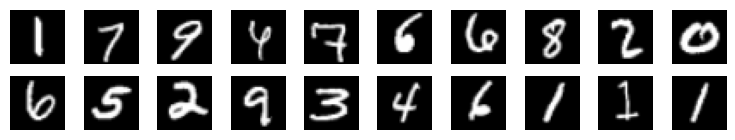

In [7]:
# Define a function to plot images with titles
def plot_batch(images):
    images = images * 0.5 + 0.5
    fig, axes = plt.subplots(2, 10, figsize=(7.5, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images and their corresponding targets
n_plot = 20
batch_images = test_batch[:n_plot]

# Plot the batch of images
plot_batch(batch_images)

## 2.- Model
### UNet

In [8]:
import torch.nn as nn
import math

In [9]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dim, scale=1.0):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.scale = scale

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = torch.outer(x * self.scale, emb)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [10]:
class upBlock(nn.Module):
    def __init__(self, in_planes, out_planes, emb_dim):
        super(upBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=in_planes, 
                         num_groups=in_planes // 4),
            nn.SiLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_planes, out_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=out_planes, 
                         num_groups=out_planes // 4),
            nn.SiLU(),
        )
        self.emb = nn.Sequential(
            nn.Linear(emb_dim, out_planes),
            nn.SiLU(),
        )

    def forward(self, x, t):
        x = self.conv1(x) + x
        return self.conv2(x) + self.emb(t)[:, :, None, None]


class DownBlock(nn.Module):
    def __init__(self, in_planes, out_planes, emb_dim):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=in_planes, 
                         num_groups=in_planes // 4),
            nn.SiLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.GroupNorm(num_channels=out_planes, 
                         num_groups=out_planes // 4),
            nn.SiLU(),
        )
        self.emb = nn.Sequential(
            nn.Linear(emb_dim, out_planes),
            nn.SiLU(),
        )

    def forward(self, x, t):
        x = self.conv1(x) + x
        return self.conv2(x) + self.emb(t)[:, :, None, None]


class UNet(nn.Module):
    def __init__(self, n_channels=64, emb_dim=64, norm_num_groups=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.inp = nn.Sequential(
            nn.Conv2d(1, n_channels, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=n_channels, 
                         num_groups=n_channels // 4),
            nn.SiLU(),
        )

        self.down1 = DownBlock(n_channels, n_channels*2, emb_dim)
        self.down2 = DownBlock(n_channels*2, n_channels*4, emb_dim)

        self.up1 = upBlock(n_channels*4, n_channels*2, emb_dim)
        self.up2 = upBlock(n_channels*4, n_channels, emb_dim)

        self.out = nn.Sequential(
            nn.GroupNorm(num_channels=n_channels, 
                         num_groups=n_channels // 4),
            nn.SiLU(),
            nn.Conv2d(n_channels, 1, 3, 1, 1, bias=False),
        )

        self.emb = nn.Sequential(
            PositionalEmbedding(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x, t):
        B = x.shape[0]
        emb = self.emb(t)
        x1 = self.inp(x)
        x2 = self.down1(x1, emb)
        x3 = self.down2(x2, emb)

        x = self.up1(x3, emb)
        x = self.up2(torch.concat([x, x2], 1), emb)
        x = self.out(x)
        return x


unet = UNet(64, 64)
noise_test = torch.randn(test_batch.shape)
t_test = torch.ones(test_batch.shape[0])
out_batch = unet(noise_test, t_test)
out_batch.shape

torch.Size([128, 1, 32, 32])

### Diffusion

#### DDPM

<img src="../img/ddpm.png" width="900"/>

__Image taken from Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, 6840-6851.__

#### DDIM

<img src="../img/ddim1.png" width="900"/>
<img src="../img/ddim2.png" width="500"/>

__Image taken from Song, J., Meng, C., & Ermon, S. (2020). Denoising diffusion implicit models. arXiv preprint arXiv:2010.02502.__


In [11]:
class Diffusion(object):
    def __init__(self, n_steps, beta_min, beta_max):
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_min, beta_max, n_steps)
        self.alphas = 1.0 - self.betas
        self.alphabar = torch.cumprod(self.alphas, dim=0)
        self.sigma = self.betas.sqrt()

    def diffuse(self, x0):
        B = len(x0)
        device = x0.device
        self.alphabar = self.alphabar.to(device)
        t = torch.randint(0, self.n_steps, (B,), dtype=torch.long).to(device)
        noise = torch.randn(x0.shape).to(device)
        alpha_t = self.alphabar[t].reshape(-1, 1, 1, 1).to(device)
        xt = alpha_t.sqrt() * x0 + (1 - alpha_t).sqrt() * noise
        return xt, t, noise

    @torch.no_grad()
    def ddpm_sample(self, model, x_shape):
        device = next(model.parameters()).device
        x_t = torch.randn(x_shape, device=device)
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            b_bar_t = 1 - self.alphabar[t]
            b_t = 1 - self.alphas[t]
            noise_pred = model(x_t, t_batch)
            mean = (x_t - b_t * noise_pred / b_bar_t.sqrt()) / self.alphas[t].sqrt()
            x_t = mean + self.sigma[t] * z
        return x_t.cpu()

    @torch.no_grad()
    def ddim_sample(self, model, x_shape, steps=50, eta=1.):
        device = next(model.parameters()).device
        x_t = torch.randn(x_shape, device=device)
        step_size = int(self.n_steps / steps)
        for t in reversed(range(0, self.n_steps, step_size)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            a_next = self.alphabar[t - step_size] if t > 0 else torch.tensor(1)
            a = self.alphabar[t]
            b_next = 1 - a_next
            b = 1 - self.alphabar[t]
            s = ((b_next / b).sqrt() * (1 - a / a_next).sqrt()) * eta
            noise_pred = model(x_t, t_batch)
            x_0 = (x_t - b.sqrt() * noise_pred) / a.sqrt()
            x_t = (b_next - s ** 2).sqrt() * noise_pred
            x_t = a_next.sqrt() * x_0 + x_t + s * z
        return x_t.cpu()


diffusion = Diffusion(n_steps=500, beta_min=0.0001, beta_max=0.02)
noisy_img, t, noise = diffusion.diffuse(test_batch)
noisy_img.shape, t.shape, noise.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]), torch.Size([128, 1, 32, 32]))

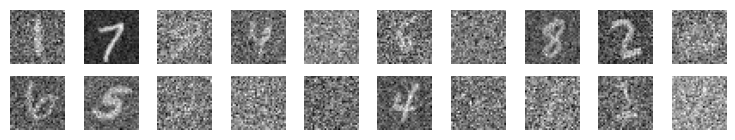

In [12]:
plot_batch(noisy_img[:n_plot])

In [13]:
optimizer = optim.Adam(unet.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [15]:
unet.to(device)

UNet(
  (inp): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (2): SiLU()
  )
  (down1): DownBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (emb): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SiLU()
    )
  )
  (down2): DownBlock(
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=

## 3.- Training

In [16]:
x_shape = (n_plot, 1, img_size, img_size)

Time for epoch 0 is 13.1405 sec Train loss: 0.1552


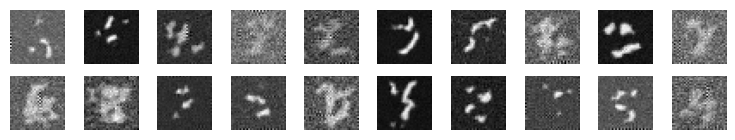

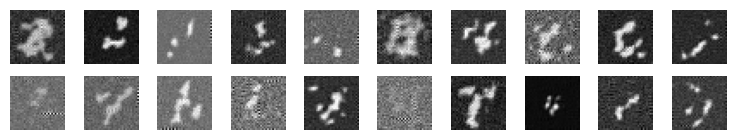

Time for epoch 1 is 13.0236 sec Train loss: 0.0486
Time for epoch 2 is 13.1103 sec Train loss: 0.0411
Time for epoch 3 is 13.0426 sec Train loss: 0.0370
Time for epoch 4 is 13.0294 sec Train loss: 0.0342
Time for epoch 5 is 13.0977 sec Train loss: 0.0320


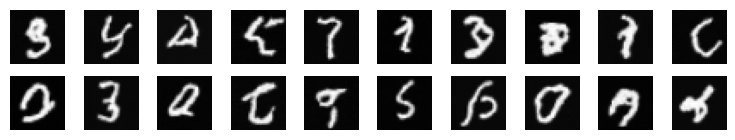

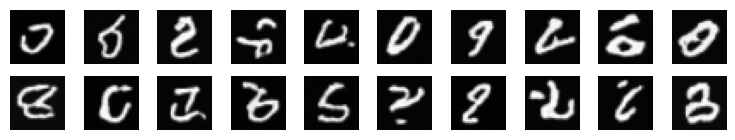

Time for epoch 6 is 13.1416 sec Train loss: 0.0310
Time for epoch 7 is 13.2714 sec Train loss: 0.0298
Time for epoch 8 is 13.1462 sec Train loss: 0.0292
Time for epoch 9 is 13.2050 sec Train loss: 0.0286
Time for epoch 10 is 12.9315 sec Train loss: 0.0282


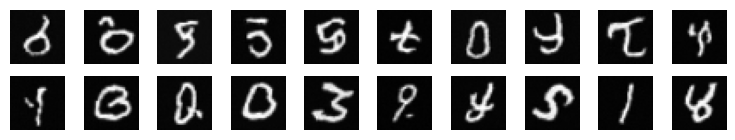

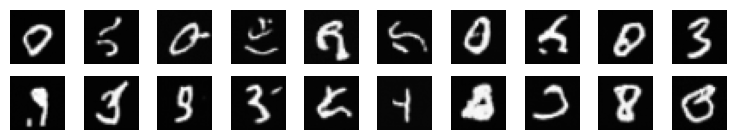

Time for epoch 11 is 12.9375 sec Train loss: 0.0277
Time for epoch 12 is 12.9966 sec Train loss: 0.0275
Time for epoch 13 is 12.8621 sec Train loss: 0.0272
Time for epoch 14 is 12.8541 sec Train loss: 0.0267
Time for epoch 15 is 12.8425 sec Train loss: 0.0263


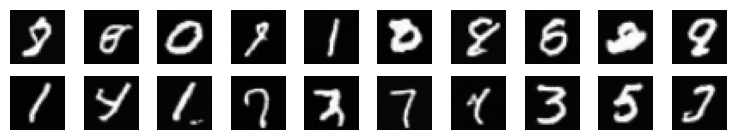

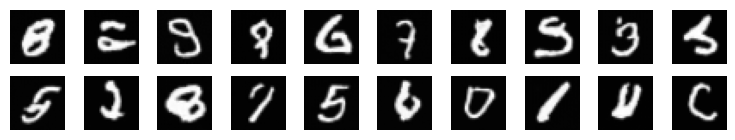

Time for epoch 16 is 12.8549 sec Train loss: 0.0262
Time for epoch 17 is 12.8676 sec Train loss: 0.0260
Time for epoch 18 is 12.8535 sec Train loss: 0.0257
Time for epoch 19 is 12.8582 sec Train loss: 0.0256
Time for epoch 20 is 12.9010 sec Train loss: 0.0255


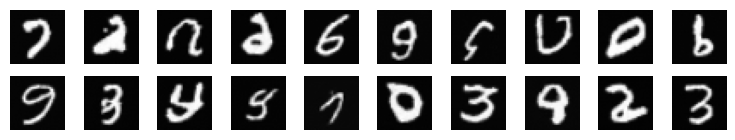

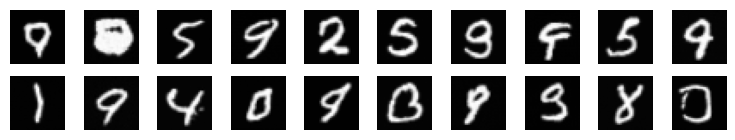

In [17]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    
    model.train()
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        xt, t, noise = diffusion.diffuse(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(xt, t)
        loss = loss_fn(outputs, noise)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')


epochs = 20
for epoch in range(epochs + 1):
    train(unet, device, train_loader, optimizer, epoch)
    if epoch % 5 == 0:
        gen_ddpm = diffusion.ddpm_sample(unet, x_shape)
        plot_batch(gen_ddpm)
        gen_ddim = diffusion.ddim_sample(unet, x_shape)
        plot_batch(gen_ddim)